# Installations and imports

In [2]:
!pip install plotnine
!pip install nilearn
!pip install --quiet --upgrade comet_ml
!pip install --quiet --upgrade comet

     |████████████████████████████████| 10.0 MB 4.7 MB/s 
     |████████████████████████████████| 299 kB 5.3 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 530 kB 42.2 MB/s 
     |████████████████████████████████| 3.1 MB 8.0 MB/s 
     |████████████████████████████████| 251 kB 53.7 MB/s 
     |████████████████████████████████| 74 kB 3.1 MB/s 


In [3]:
import os
os.getcwd()

'/content'

In [4]:
# imports 
import comet
from comet_ml import Experiment
import sklearn
import xgboost
from comet_ml import Experiment
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import average_precision_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import math
import pylab
import scipy
import plotnine
from plotnine import *
from scipy.stats import mannwhitneyu
import nilearn
from nilearn import datasets
from nilearn import connectome
from nilearn import plotting

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:96: FutureWarning:

Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.



# Data uploads

In [33]:
data_la = pd.read_csv('LA5_smri_schz_control.csv')
targets_la = pd.read_csv('LA5_actual_targets.csv')
data_la_update = pd.read_csv('la5_freesurfer6.0_all.csv')

data_aroma = pd.read_csv('aroma_SCHZ_CONTROL.csv')
data_aroma_update = pd.read_csv('AROMA_rest_LA5_261_042020.csv')
data_aroma_update.index = data_aroma_update['participant_id']

['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_L', 'Occipital_Inf_R', 'Fusiform_L', 'Fusiform_R', 'Po

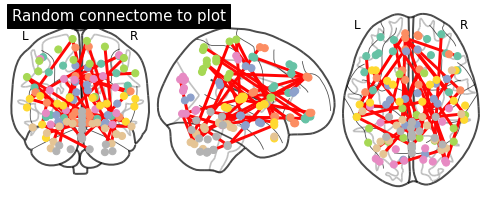

In [8]:
# labels for fMRI connectome

aal_coords = pd.read_csv('aal_atlas_coords.tsv', delimiter = "\t")
atlas_region_coords = aal_coords[['x', 'y', 'z']]
print(nilearn.datasets.fetch_atlas_aal(version='SPM12', data_dir=None, url=None, resume=True, verbose=1).labels)
connetome_to_plot = nilearn.connectome.vec_to_sym_matrix(data_aroma.loc[0][1:-1].values, diagonal=np.repeat('NaN', 116))

# test brain plotting

plotting.plot_connectome(connetome_to_plot,
                         atlas_region_coords, edge_threshold='99.5%',
                         title='Random connectome to plot',
                         )

In [34]:
# investigating shapes of data
print(targets_la.shape) # should be all subjects, but there are fewer, than in participants.tsv file
print(data_la.shape) # should be only control and schizophrenia individuals
print(data_la_update.shape) # no controls, only schiz and bipolar individuals

print(data_aroma_update.shape) # should be of the same shape as LA data, but has fewer samples

(265, 22)
(174, 929)
(264, 929)
(261, 6676)


In [11]:
print(targets_la['diagnosis'].value_counts())
targets_la.index = targets_la['participant_id']
targets_la

CONTROL    125
SCHZ        50
BIPOLAR     49
ADHD        41
Name: diagnosis, dtype: int64


,Unnamed: 0,participant_id,diagnosis,age,gender,bart,bht,dwi,pamenc,pamret,rest,scap,stopsignal,T1w,taskswitch,ScannerSerialNumber,ghost_NoGhost,label,Bipolar/Control,Bipolar/NotBipolar,ADHD/Control,Schz/Control
participant_id,,,,,,,,,,,,,,,,,,,,,,
sub-10159,0,sub-10159,CONTROL,30,F,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost,CONTROL,0.0,0,0.0,0.0
sub-10171,1,sub-10171,CONTROL,24,M,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost,CONTROL,0.0,0,0.0,0.0
sub-10189,2,sub-10189,CONTROL,49,M,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost,CONTROL,0.0,0,0.0,0.0
sub-10193,3,sub-10193,CONTROL,40,M,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,35343.0,No_ghost,CONTROL,0.0,0,0.0,0.0
sub-10206,4,sub-10206,CONTROL,21,M,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost,CONTROL,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-70079,267,sub-70079,ADHD,21,M,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,35426.0,No_ghost,ADHD,NaN,0,1.0,NaN
sub-70080,268,sub-70080,ADHD,48,M,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,35426.0,No_ghost,ADHD,NaN,0,1.0,NaN
sub-70081,269,sub-70081,ADHD,50,M,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,35426.0,No_ghost,ADHD,NaN,0,1.0,NaN


In [12]:
data_la_update.index = data_la_update['ID']
data_la_update = data_la_update.drop(columns = ['ID', 'Unnamed: 0'])


print(data_la_update.shape)
data_la_update

(264, 927)


,Left-Lateral-Ventricle_NVoxels,Left-Inf-Lat-Vent_NVoxels,Left-Cerebellum-White-Matter_NVoxels,Left-Cerebellum-Cortex_NVoxels,Left-Thalamus-Proper_NVoxels,Left-Caudate_NVoxels,Left-Putamen_NVoxels,Left-Pallidum_NVoxels,3rd-Ventricle_NVoxels,4th-Ventricle_NVoxels,Brain-Stem_NVoxels,Left-Hippocampus_NVoxels,Left-Amygdala_NVoxels,CSF_NVoxels,Left-Accumbens-area_NVoxels,Left-VentralDC_NVoxels,Left-vessel_NVoxels,Left-choroid-plexus_NVoxels,Right-Lateral-Ventricle_NVoxels,Right-Inf-Lat-Vent_NVoxels,Right-Cerebellum-White-Matter_NVoxels,Right-Cerebellum-Cortex_NVoxels,Right-Thalamus-Proper_NVoxels,Right-Caudate_NVoxels,Right-Putamen_NVoxels,Right-Pallidum_NVoxels,Right-Hippocampus_NVoxels,Right-Amygdala_NVoxels,Right-Accumbens-area_NVoxels,Right-VentralDC_NVoxels,Right-vessel_NVoxels,Right-choroid-plexus_NVoxels,5th-Ventricle_NVoxels,WM-hypointensities_NVoxels,Left-WM-hypointensities_NVoxels,Right-WM-hypointensities_NVoxels,non-WM-hypointensities_NVoxels,Left-non-WM-hypointensities_NVoxels,Right-non-WM-hypointensities_NVoxels,Optic-Chiasm_NVoxels,CC_Posterior_NVoxels,CC_Mid_Posterior_NVoxels,CC_Central_NVoxels,CC_Mid_Anterior_NVoxels,CC_Anterior_NVoxels,Left-Lateral-Ventricle_Volume_mm3,Left-Inf-Lat-Vent_Volume_mm3,Left-Cerebellum-White-Matter_Volume_mm3,Left-Cerebellum-Cortex_Volume_mm3,Left-Thalamus-Proper_Volume_mm3,Left-Caudate_Volume_mm3,Left-Putamen_Volume_mm3,Left-Pallidum_Volume_mm3,3rd-Ventricle_Volume_mm3,4th-Ventricle_Volume_mm3,Brain-Stem_Volume_mm3,Left-Hippocampus_Volume_mm3,Left-Amygdala_Volume_mm3,CSF_Volume_mm3,Left-Accumbens-area_Volume_mm3,Left-VentralDC_Volume_mm3,Left-vessel_Volume_mm3,Left-choroid-plexus_Volume_mm3,Right-Lateral-Ventricle_Volume_mm3,Right-Inf-Lat-Vent_Volume_mm3,Right-Cerebellum-White-Matter_Volume_mm3,Right-Cerebellum-Cortex_Volume_mm3,Right-Thalamus-Proper_Volume_mm3,Right-Caudate_Volume_mm3,Right-Putamen_Volume_mm3,Right-Pallidum_Volume_mm3,Right-Hippocampus_Volume_mm3,Right-Amygdala_Volume_mm3,Right-Accumbens-area_Volume_mm3,Right-VentralDC_Volume_mm3,Right-vessel_Volume_mm3,Right-choroid-plexus_Volume_mm3,5th-Ventricle_Volume_mm3,WM-hypointensities_Volume_mm3,Left-WM-hypointensities_Volume_mm3,Right-WM-hypointensities_Volume_mm3,non-WM-hypointensities_Volume_mm3,Left-non-WM-hypointensities_Volume_mm3,Right-non-WM-hypointensities_Volume_mm3,Optic-Chiasm_Volume_mm3,CC_Posterior_Volume_mm3,CC_Mid_Posterior_Volume_mm3,CC_Central_Volume_mm3,CC_Mid_Anterior_Volume_mm3,CC_Anterior_Volume_mm3,Left-Lateral-Ventricle_normMean,Left-Inf-Lat-Vent_normMean,Left-Cerebellum-White-Matter_normMean,Left-Cerebellum-Cortex_normMean,Left-Thalamus-Proper_normMean,Left-Caudate_normMean,Left-Putamen_normMean,Left-Pallidum_normMean,3rd-Ventricle_normMean,4th-Ventricle_normMean,Brain-Stem_normMean,Left-Hippocampus_normMean,Left-Amygdala_normMean,CSF_normMean,Left-Accumbens-area_normMean,Left-VentralDC_normMean,Left-vessel_normMean,Left-choroid-plexus_normMean,Right-Lateral-Ventricle_normMean,Right-Inf-Lat-Vent_normMean,Right-Cerebellum-White-Matter_normMean,Right-Cerebellum-Cortex_normMean,Right-Thalamus-Proper_normMean,Right-Caudate_normMean,Right-Putamen_normMean,Right-Pallidum_normMean,Right-Hippocampus_normMean,Right-Amygdala_normMean,Right-Accumbens-area_normMean,Right-VentralDC_normMean,Right-vessel_normMean,Right-choroid-plexus_normMean,5th-Ventricle_normMean,WM-hypointensities_normMean,Left-WM-hypointensities_normMean,Right-WM-hypointensities_normMean,non-WM-hypointensities_normMean,Left-non-WM-hypointensities_normMean,Right-non-WM-hypointensities_normMean,Optic-Chiasm_normMean,CC_Posterior_normMean,CC_Mid_Posterior_normMean,CC_Central_normMean,CC_Mid_Anterior_normMean,CC_Anterior_normMean,Left-Lateral-Ventricle_normStdDev,Left-Inf-Lat-Vent_normStdDev,Left-Cerebellum-White-Matter_normStdDev,Left-Cerebellum-Cortex_normStdDev,Left-Thalamus-Proper_normStdDev,Left-Caudate_normStdDev,Left-Putamen_normStdDev,Left-Pallidum_normStdDev,3rd-Ventricle_normStdDev,4th-Ventricle_normStdDev,Brain-Stem_normStdDev,Left-Hippo

In [13]:
data_la_update.index.values
targets_la.loc[data_la_update.index.values]
targets_la.loc[data_la_update.index.values]['diagnosis'].value_counts()

CONTROL    124
SCHZ        50
BIPOLAR     49
ADHD        41
Name: diagnosis, dtype: int64

In [14]:
print(data_la.shape)
data_la.head(10)

(174, 929)


,Unnamed: 0,Left-Lateral-Ventricle_NVoxels,Left-Inf-Lat-Vent_NVoxels,Left-Cerebellum-White-Matter_NVoxels,Left-Cerebellum-Cortex_NVoxels,Left-Thalamus-Proper_NVoxels,Left-Caudate_NVoxels,Left-Putamen_NVoxels,Left-Pallidum_NVoxels,3rd-Ventricle_NVoxels,4th-Ventricle_NVoxels,Brain-Stem_NVoxels,Left-Hippocampus_NVoxels,Left-Amygdala_NVoxels,CSF_NVoxels,Left-Accumbens-area_NVoxels,Left-VentralDC_NVoxels,Left-vessel_NVoxels,Left-choroid-plexus_NVoxels,Right-Lateral-Ventricle_NVoxels,Right-Inf-Lat-Vent_NVoxels,Right-Cerebellum-White-Matter_NVoxels,Right-Cerebellum-Cortex_NVoxels,Right-Thalamus-Proper_NVoxels,Right-Caudate_NVoxels,Right-Putamen_NVoxels,Right-Pallidum_NVoxels,Right-Hippocampus_NVoxels,Right-Amygdala_NVoxels,Right-Accumbens-area_NVoxels,Right-VentralDC_NVoxels,Right-vessel_NVoxels,Right-choroid-plexus_NVoxels,5th-Ventricle_NVoxels,WM-hypointensities_NVoxels,Left-WM-hypointensities_NVoxels,Right-WM-hypointensities_NVoxels,non-WM-hypointensities_NVoxels,Left-non-WM-hypointensities_NVoxels,Right-non-WM-hypointensities_NVoxels,Optic-Chiasm_NVoxels,CC_Posterior_NVoxels,CC_Mid_Posterior_NVoxels,CC_Central_NVoxels,CC_Mid_Anterior_NVoxels,CC_Anterior_NVoxels,Left-Lateral-Ventricle_Volume_mm3,Left-Inf-Lat-Vent_Volume_mm3,Left-Cerebellum-White-Matter_Volume_mm3,Left-Cerebellum-Cortex_Volume_mm3,Left-Thalamus-Proper_Volume_mm3,Left-Caudate_Volume_mm3,Left-Putamen_Volume_mm3,Left-Pallidum_Volume_mm3,3rd-Ventricle_Volume_mm3,4th-Ventricle_Volume_mm3,Brain-Stem_Volume_mm3,Left-Hippocampus_Volume_mm3,Left-Amygdala_Volume_mm3,CSF_Volume_mm3,Left-Accumbens-area_Volume_mm3,Left-VentralDC_Volume_mm3,Left-vessel_Volume_mm3,Left-choroid-plexus_Volume_mm3,Right-Lateral-Ventricle_Volume_mm3,Right-Inf-Lat-Vent_Volume_mm3,Right-Cerebellum-White-Matter_Volume_mm3,Right-Cerebellum-Cortex_Volume_mm3,Right-Thalamus-Proper_Volume_mm3,Right-Caudate_Volume_mm3,Right-Putamen_Volume_mm3,Right-Pallidum_Volume_mm3,Right-Hippocampus_Volume_mm3,Right-Amygdala_Volume_mm3,Right-Accumbens-area_Volume_mm3,Right-VentralDC_Volume_mm3,Right-vessel_Volume_mm3,Right-choroid-plexus_Volume_mm3,5th-Ventricle_Volume_mm3,WM-hypointensities_Volume_mm3,Left-WM-hypointensities_Volume_mm3,Right-WM-hypointensities_Volume_mm3,non-WM-hypointensities_Volume_mm3,Left-non-WM-hypointensities_Volume_mm3,Right-non-WM-hypointensities_Volume_mm3,Optic-Chiasm_Volume_mm3,CC_Posterior_Volume_mm3,CC_Mid_Posterior_Volume_mm3,CC_Central_Volume_mm3,CC_Mid_Anterior_Volume_mm3,CC_Anterior_Volume_mm3,Left-Lateral-Ventricle_normMean,Left-Inf-Lat-Vent_normMean,Left-Cerebellum-White-Matter_normMean,Left-Cerebellum-Cortex_normMean,Left-Thalamus-Proper_normMean,Left-Caudate_normMean,Left-Putamen_normMean,Left-Pallidum_normMean,3rd-Ventricle_normMean,4th-Ventricle_normMean,Brain-Stem_normMean,Left-Hippocampus_normMean,Left-Amygdala_normMean,CSF_normMean,Left-Accumbens-area_normMean,Left-VentralDC_normMean,Left-vessel_normMean,Left-choroid-plexus_normMean,Right-Lateral-Ventricle_normMean,Right-Inf-Lat-Vent_normMean,Right-Cerebellum-White-Matter_normMean,Right-Cerebellum-Cortex_normMean,Right-Thalamus-Proper_normMean,Right-Caudate_normMean,Right-Putamen_normMean,Right-Pallidum_normMean,Right-Hippocampus_normMean,Right-Amygdala_normMean,Right-Accumbens-area_normMean,Right-VentralDC_normMean,Right-vessel_normMean,Right-choroid-plexus_normMean,5th-Ventricle_normMean,WM-hypointensities_normMean,Left-WM-hypointensities_normMean,Right-WM-hypointensities_normMean,non-WM-hypointensities_normMean,Left-non-WM-hypointensities_normMean,Right-non-WM-hypointensities_normMean,Optic-Chiasm_normMean,CC_Posterior_normMean,CC_Mid_Posterior_normMean,CC_Central_normMean,CC_Mid_Anterior_normMean,CC_Anterior_normMean,Left-Lateral-Ventricle_normStdDev,Left-Inf-Lat-Vent_normStdDev,Left-Cerebellum-White-Matter_normStdDev,Left-Cerebellum-Cortex_normStdDev,Left-Thalamus-Proper_normStdDev,Left-Caudate_normStdDev,Left-Putamen_normStdDev,Left-Pallidum_normStdDev,3rd-Ventricle_normStdDev,4th-Ventricle_normStdDev,Brain-Stem_normStdDev

In [15]:
print(data_aroma.shape) # 6670 connectome values: 116 parcels from Automated Anatomical Labeling (AAL) 116 template
data_aroma.tail(10)

(58, 6672)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,...,6421,6422,6423,6424,6425,6426,6427,6428,6429,6430,6431,6432,6433,6434,6435,6436,6437,6438,6439,6440,6441,6442,6443,6444,6445,6446,6447,6448,6449,6450,6451,6452,6453,6454,6455,6456,6457,6458,6459,6460,6461,6462,6463,6464,6465,6466,6467,6468,6469,6470,6471,6472,6473,6474,6475,6476,6477,6478,6479,6480,6481,6482,6483,6484,6485,6486,6487,6488,6489,6490,6491,6492,6493,6494,6495,6496,6497,6498,6499,6500,6501,6502,6503,6504,6505,6506,6507,6508,6509,6510,6511,6512,6513,6514,6515,6516,6517,6518,6519,6520,6521,6522,6523,6524,6525,6526,6527,6528,6529,6530,6531,6532,6533,6534,6535,6536,6537,6538,6539,6540,6541,6542,6543,6544,6545,6546,6547,6548,6549,6550,6551,6552,6553,6554,6555,6556,6557,6558,6559,6560,6561,6562,6563,6564,6565,6566,6567,6568,6569,6570,6571,6572,6573,6574,6575,6576,6577,6578,6579,6580,6581,6582,6583,6584,6585,6586,6587,6588,6589,6590,6591,6592,6593,6594,6595,6596,6597,6598,6599,6600,6601,6602,6603,6604,6605,6606,6607,6608,6609,6610,6611,6612,6613,6614,6615,6616,6617,6618,6619,6620,6621,6622,6623,6624,6625,6626,6627,6628,6629,6630,6631,6632,6633,6634,6635,6636,6637,6638,6639,6640,6641,6642,6643,6644,6645,6646,6647,6648,6649,6650,6651,6652,6653,6654,6655,6656,6657,6658,6659,6660,6661,6662,6663,6664,6665,6666,6667,6668,6669,target
48,48,0.675709,0.166554,0.337137,0.558331,0.442209,0.309789,0.393649,0.263927,0.440931,0.758138,0.489276,0.548372,0.266889,0.514590,0.278707,0.767152,0.642176,0.805487,0.622496,0.515434,0.197844,0.271948,0.087216,0.233711,0.264932,0.302678,0.449732,0.652856,0.447910,0.280023,-0.081698,0.532547,0.453805,0.163407,0.206191,0.409332,0.132853,0.167935,0.235101,0.391441,0.514758,0.441355,0.391690,0.360742,0.416231,0.353208,0.443189,0.452014,0.413333,0.438431,0.423840,0.341875,0.346715,0.606646,0.524962,0.876285,0.756480,0.662677,0.667029,0.537455,0.177983,0.826086,0.332538,0.173098,0.108545,0.335936,0.354631,0.621744,0.682254,0.349331,0.420276,0.379458,0.354662,0.140807,0.261331,0.437251,0.526742,0.346678,0.665922,0.825710,0.626449,0.749433,0.594110,0.459166,0.388023,0.256695,0.214074,0.390338,0.507119,0.387660,0.353727,0.322475,0.165911,0.026951,0.157966,0.079450,0.337992,0.586398,0.635854,0.449288,0.274040,0.591829,0.599331,0.393593,0.427413,0.167714,0.548110,0.160903,0.269954,0.302360,0.471180,0.367605,0.442391,0.452759,0.190162,0.466600,0.625183,0.548920,0.598936,0.215523,0.558190,0.307567,0.465523,0.498657,0.629701,0.444210,0.450365,0.552693,0.609161,0.679508,0.758432,0.742950,0.774115,0.412047,0.139093,0.532793,0.384055,0.444978,0.479621,0.515981,0.559527,0.460183,0.418694,0.482131,0.340367,0.690918,0.652692,0.324840,0.371723,0.583691,0.417910,-0.112972,0.400750,0.583895,0.349062,0.535050,0.405362,0.533535,0.589280,0.456630,0.646529,0.648060,0.711802,0.642523,0.602072,0.668785,0.577094,0.597822,0.673852,0.766247,0.814060,0.345395,0.624551,0.286191,0.514013,0.640792,0.413271,0.297120,0.361187,0.262201,0.216046,0.551503,0.631375,0.539294,0.654875,0.575530,0.577841,0.292340,0.525405,0.665142,0.742471,0.378131,0.554731,0.674446,0.692443,0.738951,0.680916,0.687318,0.717913,0.385942,0.548106,0.579085,0.673237,0.698485,0.

In [41]:
participants = pd.read_csv('participants.tsv', delimiter = "\t")
participants.index = participants['participant_id'].values
print(participants.shape)

schizo_ind = participants['participant_id'][np.where((participants['diagnosis'] == 'CONTROL').values | (participants['diagnosis'] == 'SCHZ').values)[0]]

(272, 16)


In [18]:
# Create an experiment with your api key
experiment = Experiment(api_key = "ByaVEizMZJeCXaxVIPWAJQglH", project_name = "schizoml", log_code=True)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' and lookings in parents. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/m-osetrova/schizoml/b38bcb5980364951a0d92fc3467980e2



In [19]:
experiment.set_name('Schizo MRI')

In [42]:
# construct feature table and target from sMRI data

X = data_la.drop(columns = ['Unnamed: 0', 'target'])
print(X.shape)

y = data_la['target'].values
print(len(y))

(174, 927)
174


In [43]:
clfs = [sklearn.neighbors.KNeighborsClassifier(n_neighbors=5), LogisticRegression(C=1), RandomForestClassifier(max_depth=4, random_state=42)]

Classifiers = ['KNN', 'Logistic', 'Random Forest']
rows = ['mean cross val', 'st dev', 'score on train', 'score on test']

score = pd.DataFrame(np.ones([4,3]), index = rows, columns=Classifiers)

for j, clf in enumerate(clfs):
  approach = clf
  cros = cross_val_score(approach, X, y, scoring='roc_auc', cv=5)
  cross_validat_score = np.mean(cros)
  st_dev = np.std(cros) 
  score.iloc[0,j] = cross_validat_score
  score.iloc[1,j] = st_dev

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

for i, clf in enumerate(clfs):
  tt = clf.fit(X_train, y_train)
  train = (abs(clf.score(X_train, y_train)))
  test = (abs(clf.score(X_test, y_test)))
  score.iloc[2,i] = train
  score.iloc[3,i] = test

print('Cross-validation scores')
print("roc_auc")

display(score)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/lin

Cross-validation scores
roc_auc


,KNN,Logistic,Random Forest
mean cross val,0.556217,0.684367,0.717167
st dev,0.046399,0.065017,0.071784
score on train,0.807692,1.000000,0.976923
score on test,0.568182,0.727273,0.704545


In [22]:
# search for hyperparameters

hyper_df = pd.DataFrame(np.ones([200,4]), columns = ['N estimators', 'maximum depth', 'score on train', 'score on test'])

for n_est in range(20):
  for depth in range(10):
    j = 10*n_est + depth
    hyper_df.iloc[j, 0] = n_est + 1
    hyper_df.iloc[j, 1] = depth + 1
    xgb = XGBClassifier(use_label_encoder=False, n_estimators=n_est + 1, max_depth = depth + 1)
    xgb.fit(X_train, y_train, eval_metric='error')
    xgb_proba = xgb.predict_proba(X_test)
    train_pred = xgb.predict_proba(X_train)
    hyper_df.iloc[j, 2] = roc_auc_score(y_train, train_pred[:, 1])
    hyper_df.iloc[j, 3] = roc_auc_score(y_test, xgb_proba[:, 1])

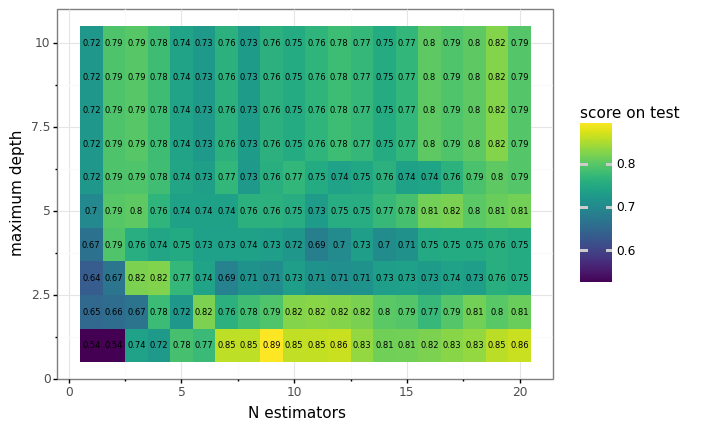

<ggplot: (8782486750005)>

In [44]:
(ggplot(hyper_df)
+ aes(x = 'N estimators', y = 'maximum depth', fill = 'score on test', label = 'score on test')
+ geom_tile()
+ geom_text(format_string='{:.2}', size = 6)
+ theme_bw()
)

In [24]:
n_estimators, max_depth, train_score, test_score = list(hyper_df.iloc[np.where(hyper_df == hyper_df['score on test'].max())[0]])

In [25]:
experiment.log_parameter('n_estimators', n_estimators)

In [26]:
experiment.log_parameter('max_depth', max_depth)

In [27]:
!python --version
#!python
import comet_ml
comet_ml.__version__

Python 3.7.12


'3.19.1'

Roc_auc score for XGBoost (test): 0.8869047619047619
Roc_auc score for XGBoost (train): 0.8806146572104019 



{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=64e599508ef7403d8bca8bd47336f08d&experimentKey=b38bcb5980364951a0d92fc3467980e2',
 'assetId': '64e599508ef7403d8bca8bd47336f08d',
 'web': 'https://www.comet.ml/api/asset/download?assetId=64e599508ef7403d8bca8bd47336f08d&experimentKey=b38bcb5980364951a0d92fc3467980e2'}

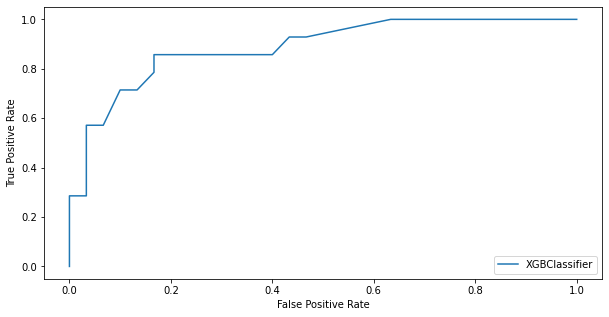

In [28]:
xgb = XGBClassifier(use_label_encoder=False, n_estimators=9, max_depth = 1)
xgb.fit(X_train, y_train, eval_metric='error')
xgb_proba = xgb.predict_proba(X_test)
train_pred = xgb.predict_proba(X_train)
print("Roc_auc score for XGBoost (test):", roc_auc_score(y_test, xgb_proba[:, 1]))
print("Roc_auc score for XGBoost (train):", roc_auc_score(y_train, train_pred[:, 1]), "\n")
fpr, tpr, thresholds = roc_curve(y_test, xgb_proba[:, 1])
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label="XGBClassifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')

experiment.log_curve("roc-auc", fpr, tpr)

In [29]:
#experiment.log_dataset_hash(X_test)
#experiment.log_parameters(params)
#experiment.log_metrics(metrics)

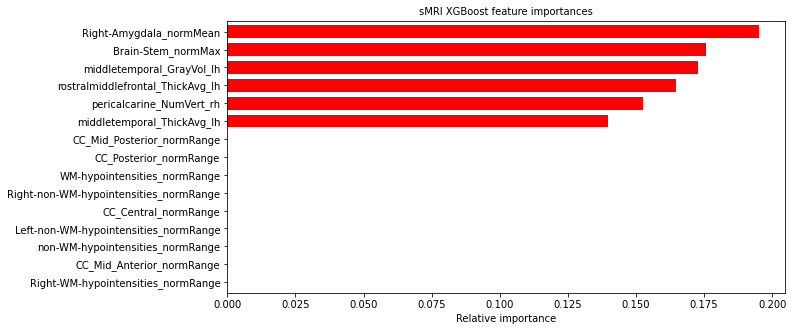

In [30]:
col_names = X.columns.values
ids = np.argsort(xgb.feature_importances_)
df = pd.DataFrame({"Xgboost": xgb.feature_importances_[ids]}, index=np.array(col_names)[ids])

df.tail(15).plot.barh(color='r', width=0.7, figsize=(10,5))
plt.title("sMRI XGBoost feature importances", fontsize=10)
plt.xlabel("Relative importance", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().get_legend().remove()

In [45]:
# construct feature table and target from rs-fMRI data

X = data_aroma.drop(columns = ['Unnamed: 0', 'target'])
print(X.shape)

y = data_aroma['target'].values
print(len(y))

(172, 6670)
172


In [46]:
clfs = [sklearn.neighbors.KNeighborsClassifier(n_neighbors=5), LogisticRegression(C=1), RandomForestClassifier(max_depth=4, random_state=42)]

Classifiers = ['KNN', 'Logistic', 'Random Forest']
rows = ['mean cross val', 'st dev', 'score on train', 'score on test']

score = pd.DataFrame(np.ones([4,3]), index = rows, columns=Classifiers)

for j, clf in enumerate(clfs):
  approach = clf
  cros = cross_val_score(approach, X, y, scoring='roc_auc', cv=5)
  cross_validat_score = np.mean(cros)
  st_dev = np.std(cros) 
  score.iloc[0,j] = cross_validat_score
  score.iloc[1,j] = st_dev

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

for i, clf in enumerate(clfs):
  tt = clf.fit(X_train, y_train)
  train = (abs(clf.score(X_train, y_train)))
  test = (abs(clf.score(X_test, y_test)))
  score.iloc[2,i] = train
  score.iloc[3,i] = test

print('Cross-validation scores')
print("roc_auc")

display(score)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.7/dist-packages/sklearn/lin

Cross-validation scores
roc_auc


,KNN,Logistic,Random Forest
mean cross val,0.572767,0.800267,0.664267
st dev,0.141852,0.102782,0.118147
score on train,0.767442,1.000000,0.961240
score on test,0.697674,0.720930,0.720930


In [47]:
# search for hyperparameters

hyper_df = pd.DataFrame(np.ones([200,4]), columns = ['N estimators', 'maximum depth', 'score on train', 'score on test'])

for n_est in range(20):
  for depth in range(10):
    j = 10*n_est + depth
    hyper_df.iloc[j, 0] = n_est + 1
    hyper_df.iloc[j, 1] = depth + 1
    xgb = XGBClassifier(use_label_encoder=False, n_estimators=n_est + 1, max_depth = depth + 1)
    xgb.fit(X_train, y_train, eval_metric='error')
    xgb_proba = xgb.predict_proba(X_test)
    train_pred = xgb.predict_proba(X_train)
    hyper_df.iloc[j, 2] = roc_auc_score(y_train, train_pred[:, 1])
    hyper_df.iloc[j, 3] = roc_auc_score(y_test, xgb_proba[:, 1])

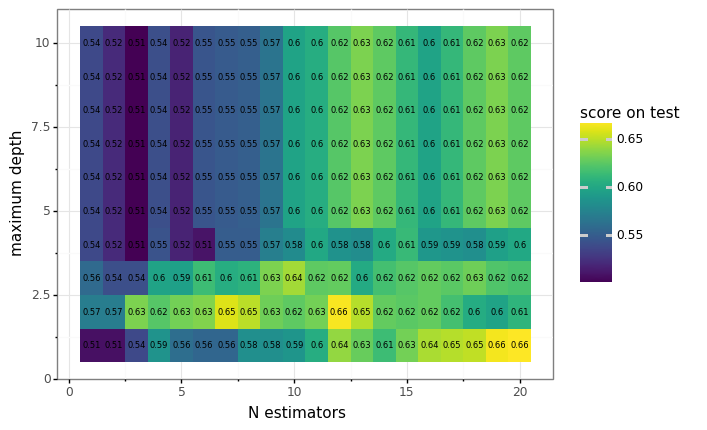

<ggplot: (8782491150881)>

In [48]:
(ggplot(hyper_df)
+ aes(x = 'N estimators', y = 'maximum depth', fill = 'score on test', label = 'score on test')
+ geom_tile()
+ geom_text(format_string='{:.2}', size = 6)
+ theme_bw()
)

Roc_auc score for XGBoost (test): 0.6612903225806451
Roc_auc score for XGBoost (train): 0.9991324465008676 



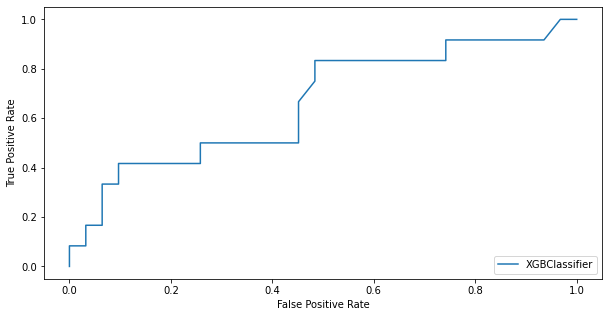

In [49]:
xgb = XGBClassifier(use_label_encoder=False, n_estimators=12, max_depth = 2)
xgb.fit(X_train, y_train, eval_metric='error')
xgb_proba = xgb.predict_proba(X_test)
train_pred = xgb.predict_proba(X_train)
print("Roc_auc score for XGBoost (test):", roc_auc_score(y_test, xgb_proba[:, 1]))
print("Roc_auc score for XGBoost (train):", roc_auc_score(y_train, train_pred[:, 1]), "\n")
fpr, tpr, thresholds = roc_curve(y_test, xgb_proba[:, 1])
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label="XGBClassifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')

Among simple methods logistic regression seems to be working best. XGBoost works better for sMRI data, but overfits a lot when applied to fMRI data.

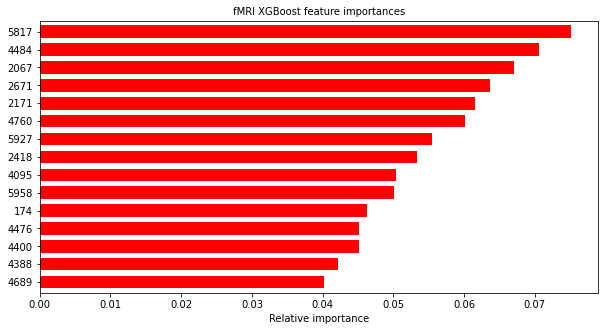

In [50]:
col_names = X.columns.values
ids = np.argsort(xgb.feature_importances_)
df = pd.DataFrame({"Xgboost": xgb.feature_importances_[ids]}, index=np.array(col_names)[ids])

df.tail(15).plot.barh(color='r', width=0.7, figsize=(10,5))
plt.title("fMRI XGBoost feature importances", fontsize=10)
plt.xlabel("Relative importance", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().get_legend().remove()

['Precentral_L', 'Precentral_R', 'Frontal_Sup_L', 'Frontal_Sup_R', 'Frontal_Sup_Orb_L', 'Frontal_Sup_Orb_R', 'Frontal_Mid_L', 'Frontal_Mid_R', 'Frontal_Mid_Orb_L', 'Frontal_Mid_Orb_R', 'Frontal_Inf_Oper_L', 'Frontal_Inf_Oper_R', 'Frontal_Inf_Tri_L', 'Frontal_Inf_Tri_R', 'Frontal_Inf_Orb_L', 'Frontal_Inf_Orb_R', 'Rolandic_Oper_L', 'Rolandic_Oper_R', 'Supp_Motor_Area_L', 'Supp_Motor_Area_R', 'Olfactory_L', 'Olfactory_R', 'Frontal_Sup_Medial_L', 'Frontal_Sup_Medial_R', 'Frontal_Med_Orb_L', 'Frontal_Med_Orb_R', 'Rectus_L', 'Rectus_R', 'Insula_L', 'Insula_R', 'Cingulum_Ant_L', 'Cingulum_Ant_R', 'Cingulum_Mid_L', 'Cingulum_Mid_R', 'Cingulum_Post_L', 'Cingulum_Post_R', 'Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R', 'Calcarine_L', 'Calcarine_R', 'Cuneus_L', 'Cuneus_R', 'Lingual_L', 'Lingual_R', 'Occipital_Sup_L', 'Occipital_Sup_R', 'Occipital_Mid_L', 'Occipital_Mid_R', 'Occipital_Inf_L', 'Occipital_Inf_R', 'Fusiform_L', 'Fusiform_R', 'Po

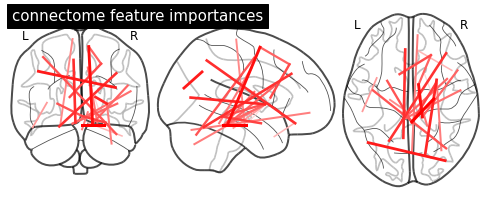

In [51]:
xgb_connectome = nilearn.connectome.vec_to_sym_matrix(xgb.feature_importances_, diagonal=np.repeat('NaN', 116))

plotting.plot_connectome(xgb_connectome,
                         atlas_region_coords, edge_threshold='99.5%',
                         title='connectome feature importances',
                         node_size = 0
                         )

atlas_labels = nilearn.datasets.fetch_atlas_aal(version='SPM12', data_dir=None, url=None, resume=True, verbose=1).labels
print(atlas_labels)

for i in range(len(xgb.feature_importances_)):
  if (xgb.feature_importances_[i] > 0):
    region_one = atlas_labels[np.where(np.nansum(xgb_connectome == xgb.feature_importances_[i], axis = 0))[0][0]]
    region_two = atlas_labels[np.where(np.nansum(xgb_connectome == xgb.feature_importances_[i], axis = 0))[0][1]]
    print("Importance = ", np.round(xgb.feature_importances_[i], 2), ", connection between ", region_one, " and ", region_two)

Roc_auc score for XGBoost (test): 0.543010752688172
Roc_auc score for XGBoost (train): 0.9855407750144592 



{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=d43ad0acb17c48bdb559b4121ccd0b8b&experimentKey=b38bcb5980364951a0d92fc3467980e2',
 'assetId': 'd43ad0acb17c48bdb559b4121ccd0b8b',
 'web': 'https://www.comet.ml/api/asset/download?assetId=d43ad0acb17c48bdb559b4121ccd0b8b&experimentKey=b38bcb5980364951a0d92fc3467980e2'}

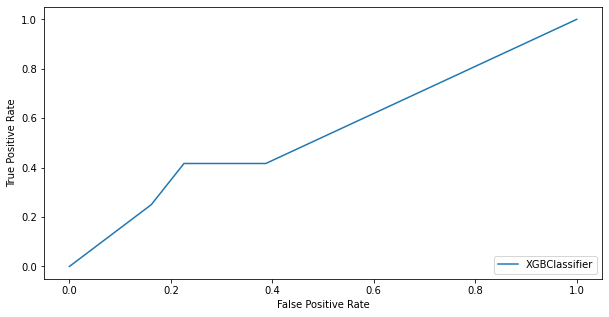

In [52]:
experiment.display()
xgb = XGBClassifier(use_label_encoder=False, n_estimators=3, max_depth = 3)
xgb.fit(X_train, y_train, eval_metric='error')
xgb_proba = xgb.predict_proba(X_test)
train_pred = xgb.predict_proba(X_train)
print("Roc_auc score for XGBoost (test):", roc_auc_score(y_test, xgb_proba[:, 1]))
print("Roc_auc score for XGBoost (train):", roc_auc_score(y_train, train_pred[:, 1]), "\n")
fpr, tpr, thresholds = roc_curve(y_test, xgb_proba[:, 1])
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label="XGBClassifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')

experiment.log_confusion_matrix(y, xgb.predict(X))
experiment.log_curve("ROC_AUC", x = fpr, y = tpr)

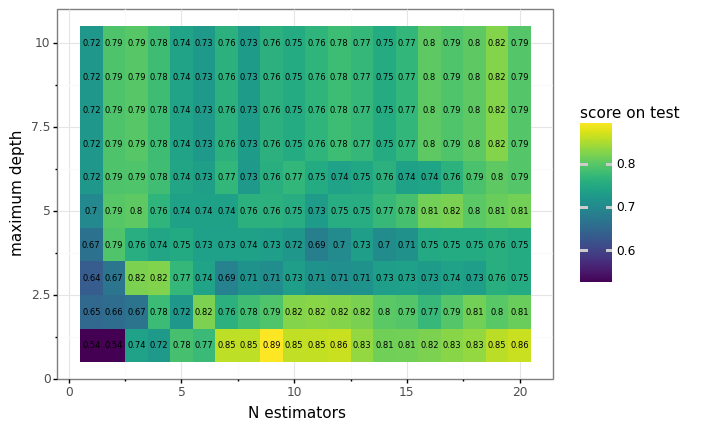

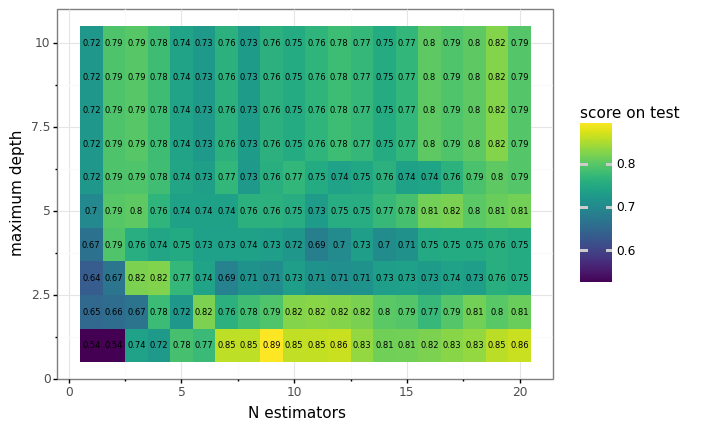

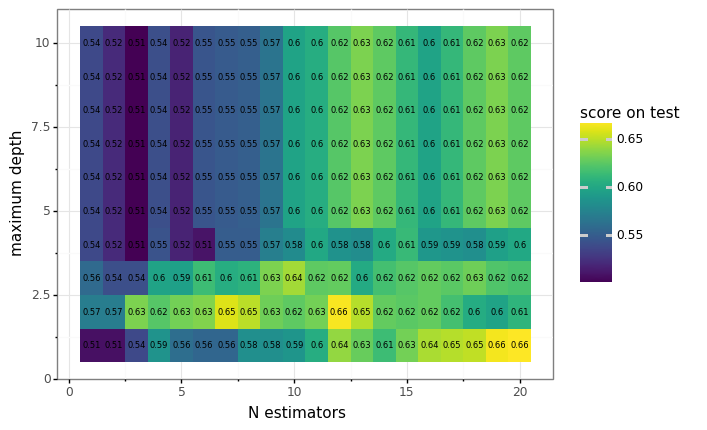

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/m-osetrova/schizoml/b38bcb5980364951a0d92fc3467980e2
COMET INFO:   Others:
COMET INFO:     Name : Schizo MRI
COMET INFO:   Parameters:
COMET INFO:     algorithm                : auto
COMET INFO:     base_score               : 0.5
COMET INFO:     begin_iteration          : 0
COMET INFO:     booster                  : gbtree
COMET INFO:     bootstrap                : True
COMET INFO:     ccp_alpha                : 0.0
COMET INFO:     class_weight             : 1
COMET INFO:     colsample_bylevel        : 1
COMET INFO:     colsample_bynode         : 1
COMET INFO:     colsample_bytree         : 1
COMET INFO:     criterion                : gini
COMET INFO:     end_iteration            : 1
COMET INFO:     eval_metric              : error
COMET INFO:    

In [53]:
experiment.end()

Extract scale values from participants' self-reports.

In [54]:
# two mood variables

hop_mood_idx = ['hopkins5', 'hopkins15', 'hopkins19', 'hopkins20', 'hopkins22', 'hopkins26', 'hopkins29', 'hopkins30', 'hopkins31', 'hopkins32', 'hopkins54'] # average from hopkins
bi_mood_idx = ['bipolarii1', 'bipolarii2', 'bipolarii3', 'bipolarii4', 'bipolarii5', 'bipolarii6', 'bipolarii7', 'bipolarii8', 'bipolarii9'] # sum from bipolar 

# two anhedonia variables

chapsoc_idx = ['chapsoc_total'] # total from chapsoc
chapphy_idx = ['chapphy_total'] # total from chapphy

# two anxiety variables

bi_anx_idx = ['bipolarii24', 'bipolarii25', 'bipolarii26', 'bipolarii27', 'bipolarii28', 'bipolarii29', 'bipolarii30', 'bipolarii31'] # sum from bipolar
hop_anx_idx = ['hopkins2', 'hopkins17', 'hopkins23', 'hopkins33', 'hopkins39', 'hopkins50'] # average from hopkins

In [55]:
# read phenotype data

hopkins = pd.read_csv('phenotype_hopkins.tsv', delimiter = "\t")
bipolar = pd.read_csv('phenotype_bipolar_ii.tsv', delimiter = "\t")
chapsoc = pd.read_csv('phenotype_chapsoc.tsv', delimiter = "\t")
chapphy = pd.read_csv('phenotype_chapphy.tsv', delimiter = "\t")

# check if ID order is the same for all tables
print(np.sum(hopkins['participant_id'] != bipolar['participant_id']))
print(np.sum(hopkins['participant_id'] != chapphy['participant_id']))
print(np.sum(chapsoc['participant_id'] != chapphy['participant_id']))

0
0
0


In [56]:
# construct scales data frame
scales_df = pd.DataFrame(data = {'Mood/Dep_Hopkins': hopkins[hop_mood_idx].mean(axis = 1).values,
    'Mood_Bipolar': bipolar[bi_mood_idx].sum(axis = 1).values,
    'Anhedonia_Chapsoc': chapsoc[chapsoc_idx].values[:,0],
    'Anhedonia_Chapphy': chapphy[chapphy_idx].values[:,0],
    'Anxiety_Bipolar': bipolar[bi_anx_idx].sum(axis = 1).values,
    'Anxiety_Hopkins': hopkins[hop_anx_idx].mean(axis = 1).values})


scales_df.index = hopkins['participant_id'].values
scales_df

,Mood/Dep_Hopkins,Mood_Bipolar,Anhedonia_Chapsoc,Anhedonia_Chapphy,Anxiety_Bipolar,Anxiety_Hopkins
sub-10159,0.181818,5.0,6,3,4.0,0.333333
sub-10171,0.272727,2.0,3,15,0.0,0.166667
sub-10189,1.181818,2.0,5,6,2.0,1.666667
sub-10193,0.181818,1.0,5,11,2.0,0.333333
sub-10206,0.090909,4.0,9,4,3.0,0.000000
...,...,...,...,...,...,...
sub-70079,0.909091,2.0,11,27,2.0,1.000000
sub-70080,0.454545,5.0,14,11,5.0,0.166667
sub-70081,1.727273,7.0,19,9,5.0,0.833333
sub-70083,0.000000,3.0,12,10,2.0,0.000000


In [57]:
participants = participants.loc[scales_df.index.values]
participants_scales = pd.concat([participants, scales_df], axis=1)

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



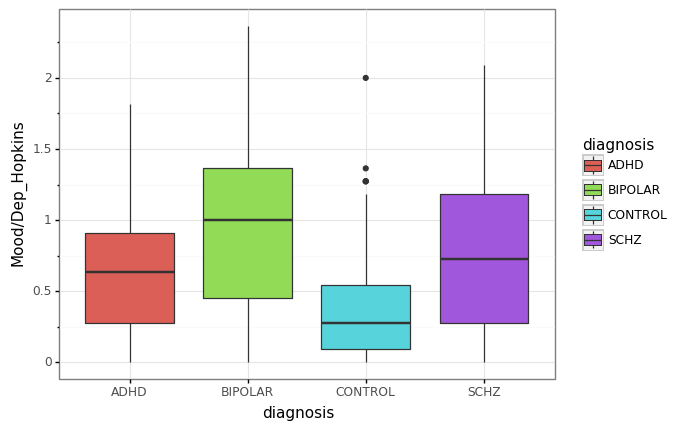

<ggplot: (8782491335485)>


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



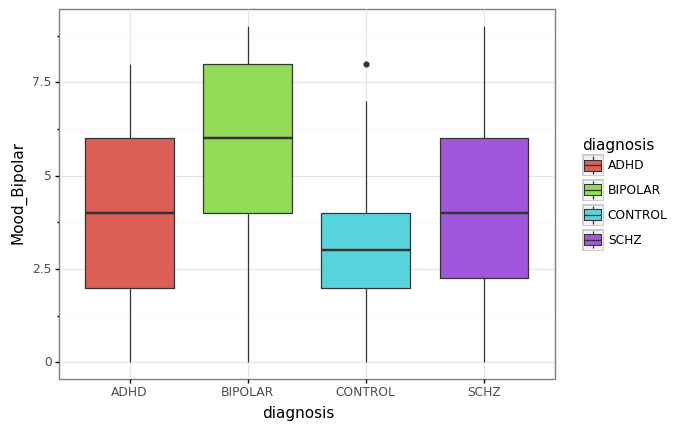

<ggplot: (8782491199553)>


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



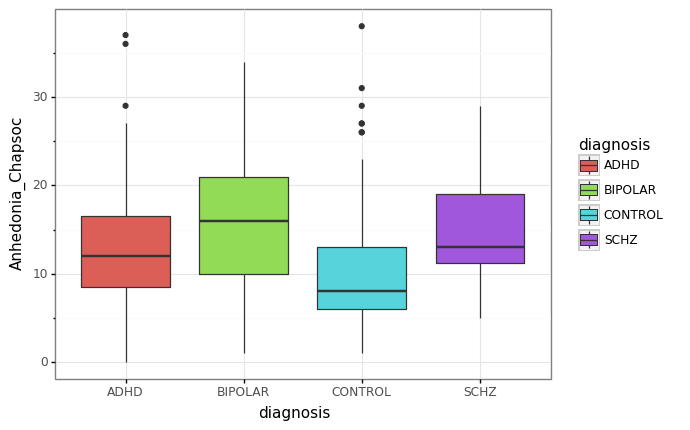

<ggplot: (8782486322189)>


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



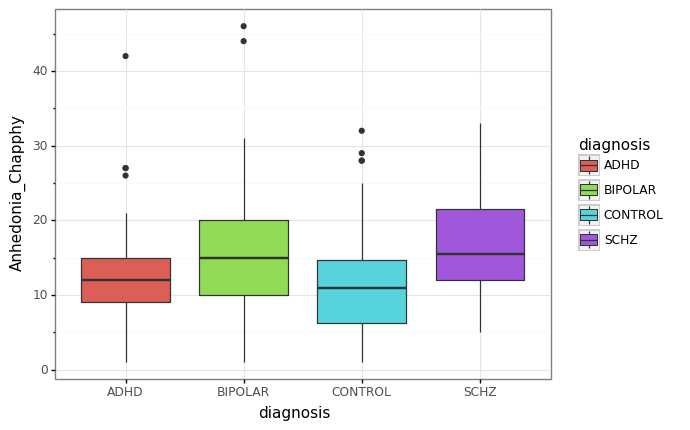

<ggplot: (8782486082501)>


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



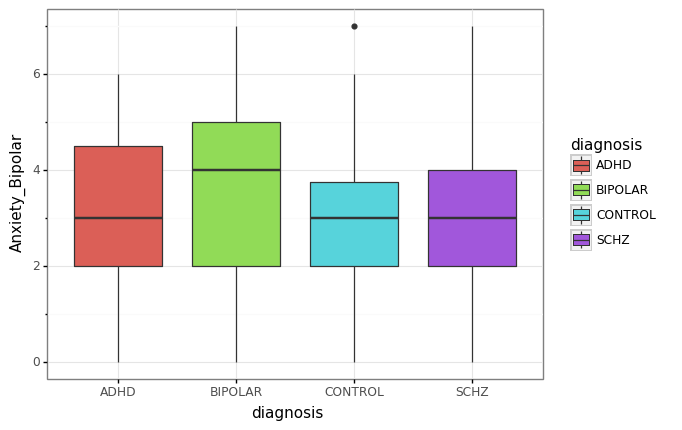

<ggplot: (8782491290933)>


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



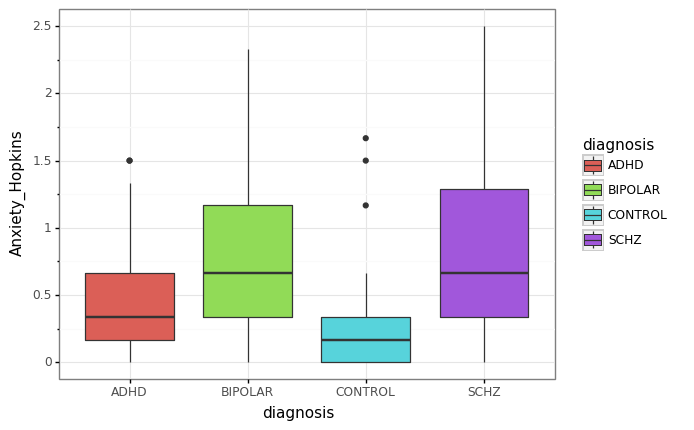

<ggplot: (8782563230237)>


In [58]:
print(ggplot(participants_scales)
+ aes(x = 'diagnosis', y = 'Mood/Dep_Hopkins', fill = 'diagnosis')
+ geom_boxplot()
+ theme_bw())

print(ggplot(participants_scales)
+ aes(x = 'diagnosis', y = 'Mood_Bipolar', fill = 'diagnosis')
+ geom_boxplot()
+ theme_bw())

print(ggplot(participants_scales)
+ aes(x = 'diagnosis', y = 'Anhedonia_Chapsoc', fill = 'diagnosis')
+ geom_boxplot()
+ theme_bw())

print(ggplot(participants_scales)
+ aes(x = 'diagnosis', y = 'Anhedonia_Chapphy', fill = 'diagnosis')
+ geom_boxplot()
+ theme_bw())

print(ggplot(participants_scales)
+ aes(x = 'diagnosis', y = 'Anxiety_Bipolar', fill = 'diagnosis')
+ geom_boxplot()
+ theme_bw())

print(ggplot(participants_scales)
+ aes(x = 'diagnosis', y = 'Anxiety_Hopkins', fill = 'diagnosis')
+ geom_boxplot()
+ theme_bw())

Almost all scales look proimsing for separating schizophrenia patients from healthy individuals (except for 'Anxiety_Bipolar' scale, which shows no visiable differences). 

## Building linear model for scales + sMRI

In [61]:
os.getcwd()

'/content'

In [63]:
# read scales data
import os
import re
scale_files = os.listdir("./scales")
scale_names = [re.sub("^phenotype_|.tsv$", "", x) for x in scale_files]
scale_values = {}

for i in range(len(scale_files)):
  scale_values[scale_names[i]] = pd.read_csv("./scales/"+scale_files[i], delimiter = "\t")
  scale_values[scale_names[i]].index = scale_values[scale_names[i]]['participant_id'].values
  print(scale_values[scale_names[i]].shape)
  scale_values[scale_names[i]] = scale_values[scale_names[i]].drop(columns = ['participant_id'])

all_scale_values = pd.concat(scale_values, axis = 1)
all_scale_values

(272, 26)
(272, 56)
(272, 159)
(272, 9)
(272, 37)
(272, 12)
(272, 53)
(272, 58)
(272, 50)


mpq                                                                                                                                                                   barratt                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           tci                                                                                                                                                                                                                           \
          mpq24 mpq209 mpq234 mpq112 mpq185 mpq2 mpq12 mpq243 mpq147 mpq92 mpq251 mpq159 mpq79 mpq124 mpq103 mpq57 mpq136 mpq38 mpq195 mpq219 mpq172 mpq266 mpq_score mpq47 mpq70 bis_1sc barratt4 bis_2npimp barratt2 bis_1cogcom bis_parcel8 barratt10 barratt14 barratt8 bis_parcel4 barratt18 bis_2motimp barratt13 bis_parcel9 barratt6 barratt26 barratt25 bis_parcel2 barratt9 bis_parcel1 bis_1atten barratt1 barratt23 barratt24 barratt12 bis_factor2 barratt30 bis_factor1_ci bis_factor1 barratt5 barratt21 bis_parcel7 barratt20 barratt7 barratt19 barratt16 barratt3 barratt17 bis_briefbis bis_parcel5 bis_2attimp barratt15 bis_1coginst bis_parcel6 barratt29 barratt22 bis_1mot barratt27 bis_parcel3 bis_1pers bis_factor2_bi barratt28 bis_parcel10 bis_parcel11 barratt11 tci137p tci236t tci154t tci62p reward_dependence tci14t tci60p novelty tci34t tci27t tci35t tci139t tci174t tci55t tci2t tci83t tci213t tci147t tci61t tci203t tci44t tci22t tci200p tci113t tci126p ps1 tci180t tci211t tci153p   
sub-10159   0.0      1    1.0    1.0    0.0  0.0   1.0    0.0    1.0     0      1    0.0   0.0    0.0    1.0   0.0    1.0   0.0    0.0    0.0    1.0    1.0        15     1   1.0      13        3         23        2          10    3.333333         2         2        3    3.000000         1          28         1         2.5        2         2         4         1.5        4         2.0          7        4         1         2         3    7.666667         3            5.5    9.750000        1         2         1.5         2        3         2         4        3         2           13    2.666667          13         4            6         2.0         3         3       19         3         1.0         9       6.666667         1     1.666667         1.25         1     1.0     1.0     0.0      1                14      0    1.0      29      0    1.0    0.0     0.0     1.0      1     1    1.0       1     1.0    0.0     0.0      0    0.0     1.0     0.0     1.0   8     1.0     0.0     0.0   
sub-10171   0.0      0    0.0    1.0    1.0  0.0   1.0    1.0    0.0     1      0    1.0   1.0    1.0    0.0   1.0    1.0   1.0    1.0    1.0    0.0    1.0         4     0   1.0      17        4         26        3           9    1.666667         4         3        2    2.000000         2          28         3         2.5        3         3         2         3.0        2         3.0         13        2         3         2         2   10.500000         3            8.5   12.750000        3         2         3.0         3        2         3         2        2         3           24    2.000000          21         3            8         3.0         3         2       19         2         2.5         9       8.000000         3     3.000000         2.25         2     1.0     1.0     0.0      1                18      0    0.0      28      0    0.0    0.0     0.0     1.0      0     1    1.0       1     1.0    0.0     0.0      0    0.0     0.0     0.0     0.0   1     0.0     0.0     0.0   
sub-10189   1.0      0    1.

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



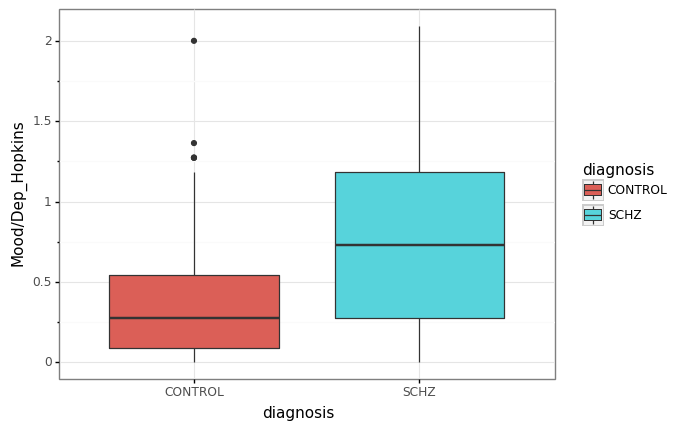

<ggplot: (8782486084281)>


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



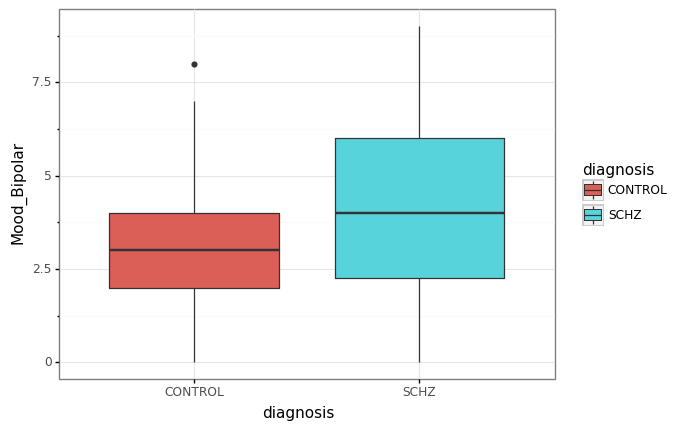

<ggplot: (8782491199541)>


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



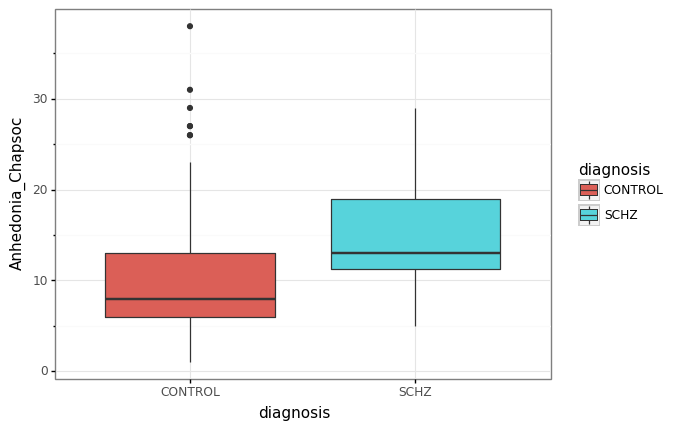

<ggplot: (8782486404561)>


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



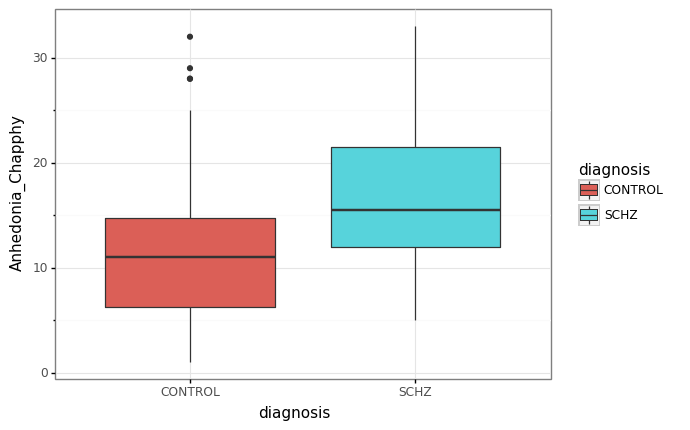

<ggplot: (8782486393489)>


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



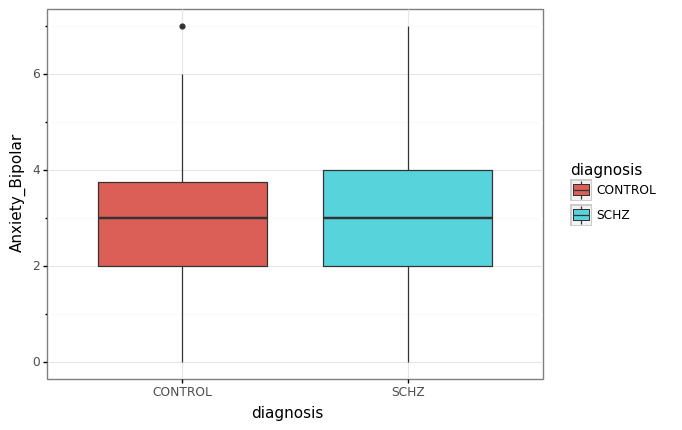

<ggplot: (8782486410017)>


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_boxplot.py:86: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



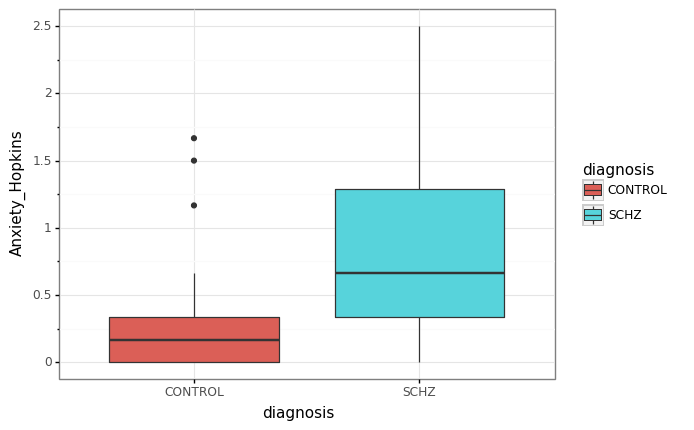

<ggplot: (8782486703297)>


In [64]:
schizo_scales = pd.concat((participants_scales, schizo_ind), axis = 1, join = 'inner').drop(columns = ['participant_id'])

print(ggplot(schizo_scales)
+ aes(x = 'diagnosis', y = 'Mood/Dep_Hopkins', fill = 'diagnosis')
+ geom_boxplot()
+ theme_bw())

print(ggplot(schizo_scales)
+ aes(x = 'diagnosis', y = 'Mood_Bipolar', fill = 'diagnosis')
+ geom_boxplot()
+ theme_bw())

print(ggplot(schizo_scales)
+ aes(x = 'diagnosis', y = 'Anhedonia_Chapsoc', fill = 'diagnosis')
+ geom_boxplot()
+ theme_bw())

print(ggplot(schizo_scales)
+ aes(x = 'diagnosis', y = 'Anhedonia_Chapphy', fill = 'diagnosis')
+ geom_boxplot()
+ theme_bw())

print(ggplot(schizo_scales)
+ aes(x = 'diagnosis', y = 'Anxiety_Bipolar', fill = 'diagnosis')
+ geom_boxplot()
+ theme_bw())

print(ggplot(schizo_scales)
+ aes(x = 'diagnosis', y = 'Anxiety_Hopkins', fill = 'diagnosis')
+ geom_boxplot()
+ theme_bw())

In [65]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
import sklearn.metrics as sm

In [66]:
performance = {}

for temp_scale in scales_df.columns:
  performance[temp_scale] = pd.DataFrame(np.ones([3,5]),
                                        columns = ['mean absolute error', 'mean squared error', 'median absolute error', 'explained variance score', 'R2'],
                                        index = ['scales', 'scales + sMRI', 'scales + sMRI + fMRI'])

(180, 440)
(180, 1)
mse = 0.2678370943432579
r2 = 0.020641933421030045
explained variance = 0.021222982529433887
Index([('eysenck', 'eysenck50'), ('barratt', 'barratt15'), ('dickman', 'dick42'), ('eysenck', 'eysenck40'), ('golden', 'golden1')], dtype='object')


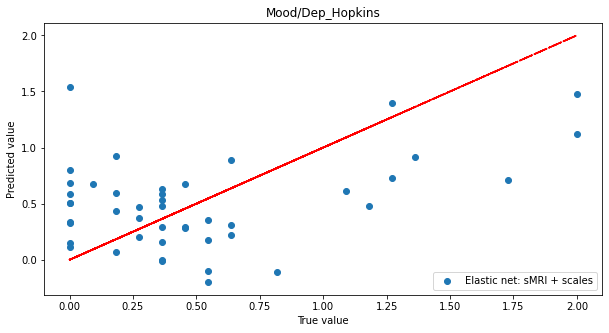

(180, 440)
(180, 1)
mse = 1.8945476046853535
r2 = 0.42395512019702086
explained variance = 0.42712535135257834
Index([('tci', 'tci210t'), ('chaphyp', 'chaphypo22'), ('eysenck', 'eysenck40'), ('tci', 'tci53t'), ('eysenck', 'eysenck20')], dtype='object')


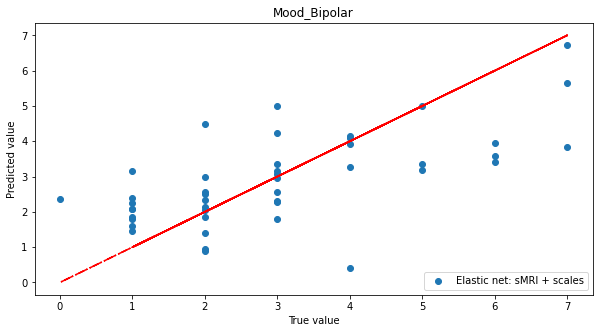

(180, 440)
(180, 1)
mse = 17.323778177050684
r2 = 0.574883048854488
explained variance = 0.6239645568137255
Index([('tci', 'tci44t'), ('tci', 'rd3'), ('tci', 'tci117t'), ('eysenck', 'eysenck35'), ('tci', 'tci231t')], dtype='object')


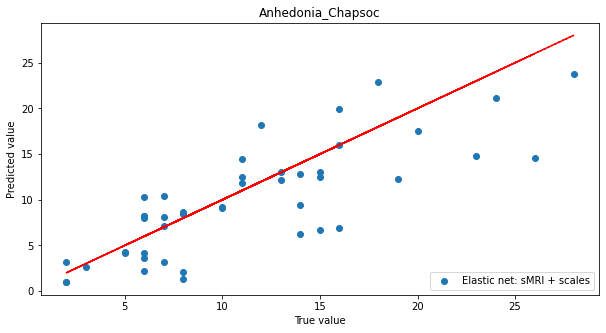

(180, 440)
(180, 1)
mse = 35.362263244820625
r2 = 0.18678360281228112
explained variance = 0.18693650710693133
Index([('dickman', 'dick14'), ('tci', 'tci119t'), ('tci', 'tci143t'), ('tci', 'tci3t'), ('eysenck', 'eysenck46')], dtype='object')


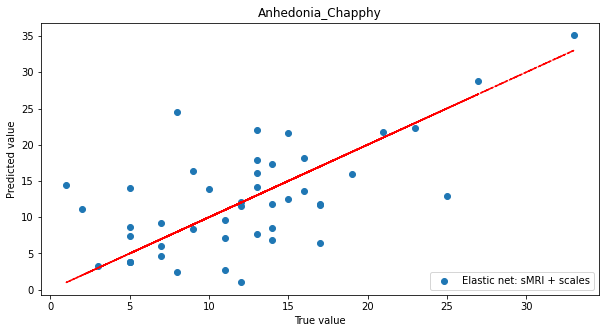

(180, 440)
(180, 1)
mse = 2.454951908460238
r2 = -0.1454556715741897
explained variance = -0.14480849811103913
Index([('mpq', 'mpq103'), ('chapper', 'chapper4'), ('chaphyp', 'chaphypo33'), ('eysenck', 'eysenck23'), ('tci', 'tci55p')], dtype='object')


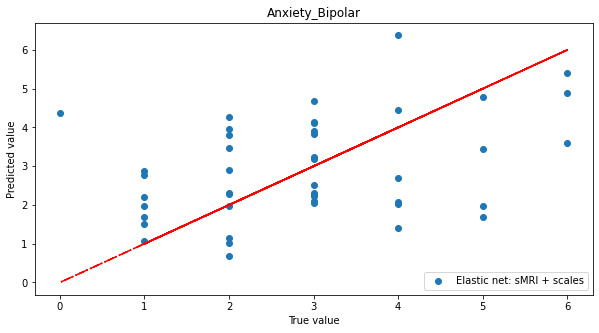

(180, 440)
(180, 1)
mse = 0.19121801521487974
r2 = 0.139306414598374
explained variance = 0.14748149838263358
Index([('tci', 'tci230t'), ('chapper', 'chapper33'), ('dickman', 'dick33'), ('mpq', 'mpq147'), ('chapper', 'chapper20')], dtype='object')


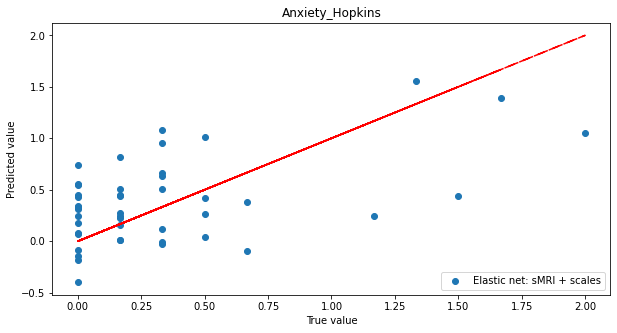

In [67]:
schizo_ind = participants['participant_id'][np.where((participants['diagnosis'] == 'CONTROL').values | (participants['diagnosis'] == 'SCHZ').values)[0]]

X = all_scale_values
X = pd.concat((X, schizo_ind), axis = 1, join = 'inner').drop(columns = ['participant_id'])
X = X[X.columns[np.where((X.isnull().sum(axis = 0) == 0).values)[0]]]
X = X[X.columns[np.where(X.std() != 0)[0]]]
X = (X - X.mean())/X.std()

for temp_scale in scales_df.columns:
  y = scales_df.loc[X.index][temp_scale]
  y = pd.concat((y, schizo_ind), axis = 1, join = 'inner').drop(columns = ['participant_id'])

  print(X.shape)
  print(y.shape)

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

  enet = ElasticNet(random_state = 42, max_iter = 100000, alpha = 0.01, l1_ratio = 0.1)
  
  enet.fit(X_train, y_train)

  test_pred = enet.predict(X_test)
  train_pred = enet.predict(X_train)

  
  mean_error = sm.mean_absolute_error(y_test, test_pred) 
  mse = sm.mean_squared_error(y_test, test_pred)
  median_error = sm.median_absolute_error(y_test, test_pred) 
  expl_var = sm.explained_variance_score(y_test, test_pred)
  r2 = sm.r2_score(y_test, test_pred)

  performance[temp_scale].loc['scales']['mean absolute error'] = mean_error
  performance[temp_scale].loc['scales']['mean squared error'] = mse
  performance[temp_scale].loc['scales']['median absolute error'] = median_error
  performance[temp_scale].loc['scales']['explained variance score'] = expl_var
  performance[temp_scale].loc['scales']['R2'] = r2

  print("mse =", mse)
  print("r2 =", r2)
  print("explained variance =", expl_var)
  experiment.log_metrics({"mean absolute error": mean_error,
                          "mean squared error": mse,
                          "median absolute error": median_error,
                          "explained variance score": expl_var,
                          "R2": r2})

  print(X.columns[np.argsort(np.abs(enet.coef_))[-5:]])

  plt.figure(figsize=(10, 5))
  plt.scatter(y_test, test_pred, label="Elastic net: sMRI + scales")
  plt.plot(y_test, y_test, color = 'r', linestyle='dashdot')
  plt.xlabel("True value")
  plt.ylabel("Predicted value")
  plt.legend(loc='lower right')
  plt.title(temp_scale)
  plt.show()


In [73]:
data_la_update.index = data_la_update['ID'].values
data_la_update = data_la_update.drop(columns = ['Unnamed: 0', 'ID'])
data_la_update

,Left-Lateral-Ventricle_NVoxels,Left-Inf-Lat-Vent_NVoxels,Left-Cerebellum-White-Matter_NVoxels,Left-Cerebellum-Cortex_NVoxels,Left-Thalamus-Proper_NVoxels,Left-Caudate_NVoxels,Left-Putamen_NVoxels,Left-Pallidum_NVoxels,3rd-Ventricle_NVoxels,4th-Ventricle_NVoxels,Brain-Stem_NVoxels,Left-Hippocampus_NVoxels,Left-Amygdala_NVoxels,CSF_NVoxels,Left-Accumbens-area_NVoxels,Left-VentralDC_NVoxels,Left-vessel_NVoxels,Left-choroid-plexus_NVoxels,Right-Lateral-Ventricle_NVoxels,Right-Inf-Lat-Vent_NVoxels,Right-Cerebellum-White-Matter_NVoxels,Right-Cerebellum-Cortex_NVoxels,Right-Thalamus-Proper_NVoxels,Right-Caudate_NVoxels,Right-Putamen_NVoxels,Right-Pallidum_NVoxels,Right-Hippocampus_NVoxels,Right-Amygdala_NVoxels,Right-Accumbens-area_NVoxels,Right-VentralDC_NVoxels,Right-vessel_NVoxels,Right-choroid-plexus_NVoxels,5th-Ventricle_NVoxels,WM-hypointensities_NVoxels,Left-WM-hypointensities_NVoxels,Right-WM-hypointensities_NVoxels,non-WM-hypointensities_NVoxels,Left-non-WM-hypointensities_NVoxels,Right-non-WM-hypointensities_NVoxels,Optic-Chiasm_NVoxels,CC_Posterior_NVoxels,CC_Mid_Posterior_NVoxels,CC_Central_NVoxels,CC_Mid_Anterior_NVoxels,CC_Anterior_NVoxels,Left-Lateral-Ventricle_Volume_mm3,Left-Inf-Lat-Vent_Volume_mm3,Left-Cerebellum-White-Matter_Volume_mm3,Left-Cerebellum-Cortex_Volume_mm3,Left-Thalamus-Proper_Volume_mm3,Left-Caudate_Volume_mm3,Left-Putamen_Volume_mm3,Left-Pallidum_Volume_mm3,3rd-Ventricle_Volume_mm3,4th-Ventricle_Volume_mm3,Brain-Stem_Volume_mm3,Left-Hippocampus_Volume_mm3,Left-Amygdala_Volume_mm3,CSF_Volume_mm3,Left-Accumbens-area_Volume_mm3,Left-VentralDC_Volume_mm3,Left-vessel_Volume_mm3,Left-choroid-plexus_Volume_mm3,Right-Lateral-Ventricle_Volume_mm3,Right-Inf-Lat-Vent_Volume_mm3,Right-Cerebellum-White-Matter_Volume_mm3,Right-Cerebellum-Cortex_Volume_mm3,Right-Thalamus-Proper_Volume_mm3,Right-Caudate_Volume_mm3,Right-Putamen_Volume_mm3,Right-Pallidum_Volume_mm3,Right-Hippocampus_Volume_mm3,Right-Amygdala_Volume_mm3,Right-Accumbens-area_Volume_mm3,Right-VentralDC_Volume_mm3,Right-vessel_Volume_mm3,Right-choroid-plexus_Volume_mm3,5th-Ventricle_Volume_mm3,WM-hypointensities_Volume_mm3,Left-WM-hypointensities_Volume_mm3,Right-WM-hypointensities_Volume_mm3,non-WM-hypointensities_Volume_mm3,Left-non-WM-hypointensities_Volume_mm3,Right-non-WM-hypointensities_Volume_mm3,Optic-Chiasm_Volume_mm3,CC_Posterior_Volume_mm3,CC_Mid_Posterior_Volume_mm3,CC_Central_Volume_mm3,CC_Mid_Anterior_Volume_mm3,CC_Anterior_Volume_mm3,Left-Lateral-Ventricle_normMean,Left-Inf-Lat-Vent_normMean,Left-Cerebellum-White-Matter_normMean,Left-Cerebellum-Cortex_normMean,Left-Thalamus-Proper_normMean,Left-Caudate_normMean,Left-Putamen_normMean,Left-Pallidum_normMean,3rd-Ventricle_normMean,4th-Ventricle_normMean,Brain-Stem_normMean,Left-Hippocampus_normMean,Left-Amygdala_normMean,CSF_normMean,Left-Accumbens-area_normMean,Left-VentralDC_normMean,Left-vessel_normMean,Left-choroid-plexus_normMean,Right-Lateral-Ventricle_normMean,Right-Inf-Lat-Vent_normMean,Right-Cerebellum-White-Matter_normMean,Right-Cerebellum-Cortex_normMean,Right-Thalamus-Proper_normMean,Right-Caudate_normMean,Right-Putamen_normMean,Right-Pallidum_normMean,Right-Hippocampus_normMean,Right-Amygdala_normMean,Right-Accumbens-area_normMean,Right-VentralDC_normMean,Right-vessel_normMean,Right-choroid-plexus_normMean,5th-Ventricle_normMean,WM-hypointensities_normMean,Left-WM-hypointensities_normMean,Right-WM-hypointensities_normMean,non-WM-hypointensities_normMean,Left-non-WM-hypointensities_normMean,Right-non-WM-hypointensities_normMean,Optic-Chiasm_normMean,CC_Posterior_normMean,CC_Mid_Posterior_normMean,CC_Central_normMean,CC_Mid_Anterior_normMean,CC_Anterior_normMean,Left-Lateral-Ventricle_normStdDev,Left-Inf-Lat-Vent_normStdDev,Left-Cerebellum-White-Matter_normStdDev,Left-Cerebellum-Cortex_normStdDev,Left-Thalamus-Proper_normStdDev,Left-Caudate_normStdDev,Left-Putamen_normStdDev,Left-Pallidum_normStdDev,3rd-Ventricle_normStdDev,4th-Ventricle_normStdDev,Brain-Stem_normStdDev,Left-Hippo

(174, 1337)
(174, 1)
mse = 0.2740735677545762
r2 = -0.1796236736898229
explained variance = -0.15619719381378117
Index([('dickman', 'dick33'), ('dickman', 'dick42'), ('tci', 'tci156t'), 'Right-Accumbens-area_normMin', ('barratt', 'barratt24')], dtype='object')


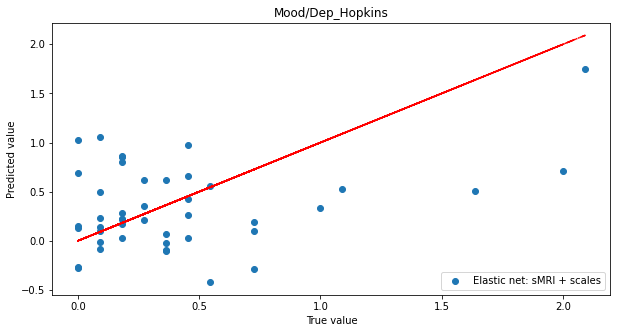

(174, 1337)
(174, 1)
mse = 1.6681398081181902
r2 = 0.33053095594593374
explained variance = 0.42147051489552
Index([('eysenck', 'eysenck40'), ('tci', 'tci65t'), ('tci', 'tci81t'), ('eysenck', 'eysenck49'), ('tci', 'tci53t')], dtype='object')


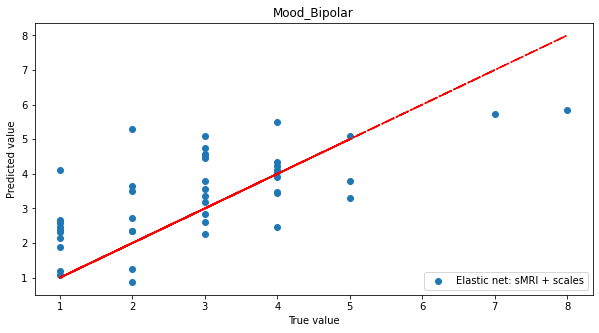

(174, 1337)
(174, 1)
mse = 19.446146537350224
r2 = 0.5555114027755932
explained variance = 0.5730493276059225
Index([('tci', 'tci231t'), ('eysenck', 'eysenck5'), ('tci', 'tci117t'), ('eysenck', 'eysenck35'), ('tci', 'rd3')], dtype='object')


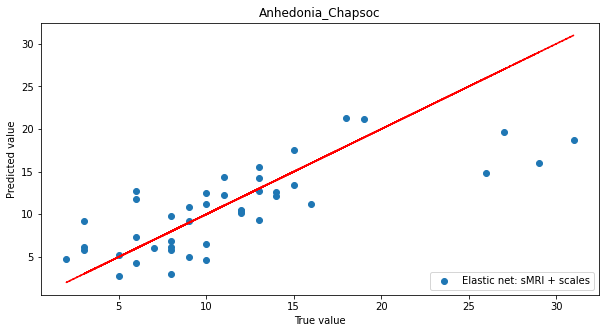

(174, 1337)
(174, 1)
mse = 30.642681829721333
r2 = 0.3221946892013562
explained variance = 0.3375897530392884
Index([('chaphyp', 'chaphypo39'), ('dickman', 'dick25'), 'cuneus_ThickAvg_rh', ('tci', 'tci53t'), ('eysenck', 'eysenck46')], dtype='object')


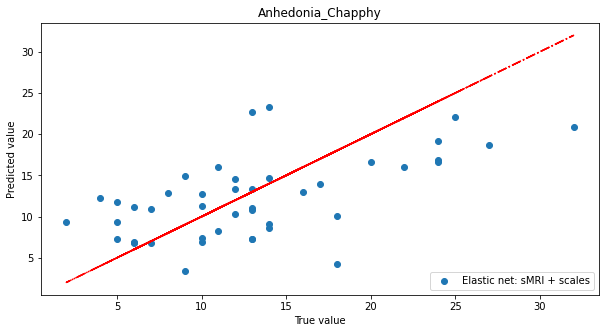

(174, 1337)
(174, 1)
mse = 1.5851436911498924
r2 = 0.3019021414772085
explained variance = 0.31206243195982486
Index(['inferiortemporal_ThickStd_lh', ('mpq', 'mpq79'), ('dickman', 'dick37'), ('tci', 'tci46t'), ('dickman', 'dick7')], dtype='object')


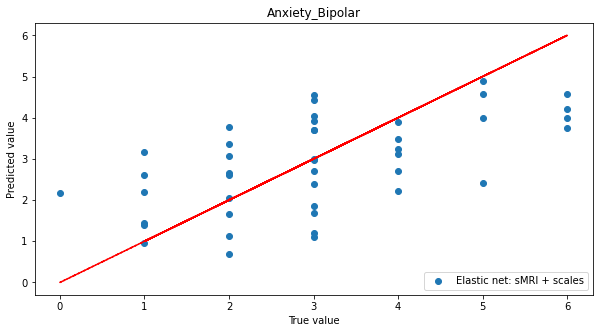

(174, 1337)
(174, 1)
mse = 0.17083506676071034
r2 = -0.17051915188305822
explained variance = -0.1409283219020807
Index([('dickman', 'dick19'), 'entorhinal_MeanCurv_lh', ('chapper', 'chapper20'), ('chapper', 'chapper33'), ('chapper', 'chapper28')], dtype='object')


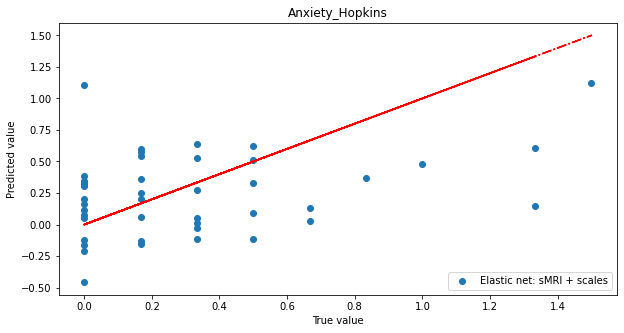

In [74]:
schizo_ind = participants['participant_id'][np.where((participants['diagnosis'] == 'CONTROL').values | (participants['diagnosis'] == 'SCHZ').values)[0]]

X = pd.concat((data_la_update, all_scale_values), axis = 1, join = 'inner')
X = pd.concat((X, schizo_ind), axis = 1, join = 'inner').drop(columns = ['participant_id'])
X = X[X.columns[np.where((X.isnull().sum(axis = 0) == 0).values)[0]]]
X = X[X.columns[np.where(X.std() != 0)[0]]]
X = (X - X.mean())/X.std()

for temp_scale in scales_df.columns:
  y = scales_df.loc[X.index][temp_scale]
  y = pd.concat((y, schizo_ind), axis = 1, join = 'inner').drop(columns = ['participant_id'])

  print(X.shape)
  print(y.shape)

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

  enet = ElasticNet(random_state = 42, max_iter = 100000, alpha = 0.01, l1_ratio = 0.1)
  
  enet.fit(X_train, y_train)

  test_pred = enet.predict(X_test)
  train_pred = enet.predict(X_train)

  
  mean_error = sm.mean_absolute_error(y_test, test_pred) 
  mse = sm.mean_squared_error(y_test, test_pred)
  median_error = sm.median_absolute_error(y_test, test_pred) 
  expl_var = sm.explained_variance_score(y_test, test_pred)
  r2 = sm.r2_score(y_test, test_pred)
  experiment.log_metrics({"mean absolute error": mean_error,
                          "mean squared error": mse,
                          "median absolute error": median_error,
                          "explained variance score": expl_var,
                          "R2": r2})

  performance[temp_scale].loc['scales + sMRI']['mean absolute error'] = mean_error
  performance[temp_scale].loc['scales + sMRI']['mean squared error'] = mse
  performance[temp_scale].loc['scales + sMRI']['median absolute error'] = median_error
  performance[temp_scale].loc['scales + sMRI']['explained variance score'] = expl_var
  performance[temp_scale].loc['scales + sMRI']['R2'] = r2

  print("mse =", mse)
  print("r2 =", r2)
  print("explained variance =", expl_var)

  print(X.columns[np.argsort(np.abs(enet.coef_))[-5:]])

  plt.figure(figsize=(10, 5))
  plt.scatter(y_test, test_pred, label="Elastic net: sMRI + scales")
  plt.plot(y_test, y_test, color = 'r', linestyle='dashdot')
  plt.xlabel("True value")
  plt.ylabel("Predicted value")
  plt.legend(loc='lower right')
  plt.title(temp_scale)
  plt.show()



In [80]:
data_aroma_update = data_aroma_update.drop(columns = ['Unnamed: 0', 'diagnosis', 'age', 'gender', 'participant_id', 'files'])

(171, 8007)
(171, 1)
Index(['CC_Mid_Anterior_normStdDev', 'temporalpole_ThickStd_rh', '6270', ('chapper', 'chapper28'), ('chapper', 'chapper20')], dtype='object')


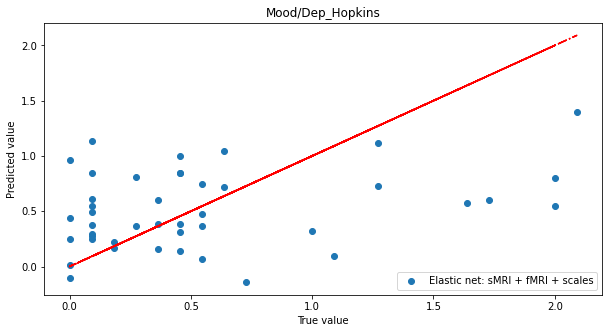

(171, 8007)
(171, 1)
Index([('chaphyp', 'chaphypo22'), ('eysenck', 'eysenck49'), ('golden', 'golden_sumscore'), ('tci', 'tci65t'), ('tci', 'tci53t')], dtype='object')


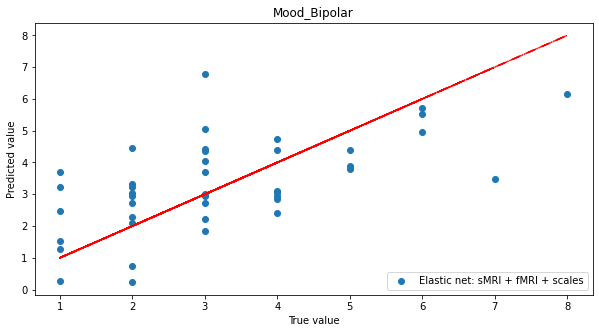

(171, 8007)
(171, 1)
Index([('golden', 'golden1'), ('tci', 'tci117t'), ('tci', 'reward_dependence'), ('tci', 'tci231t'), ('tci', 'rd3')], dtype='object')


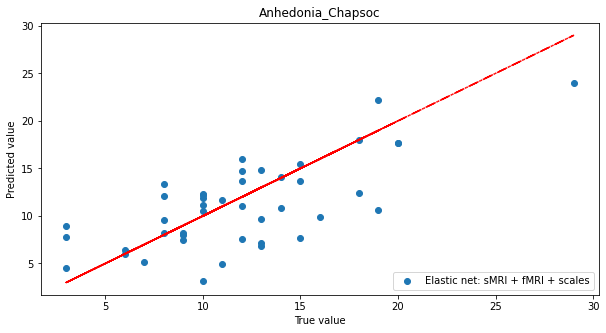

(171, 8007)
(171, 1)
Index([('tci', 'tci83t'), ('tci', 'tci53t'), ('tci', 'tci141t'), ('tci', 'reward_dependence'), ('eysenck', 'eysenck46')], dtype='object')


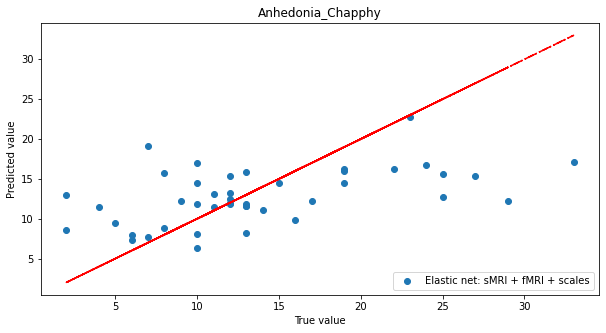

(171, 8007)
(171, 1)
Index([('eysenck', 'eysenck8'), 'inferiortemporal_ThickStd_lh', ('tci', 'tci46t'), 'Left-choroid-plexus_normMax', ('tci', 'tci55t')], dtype='object')


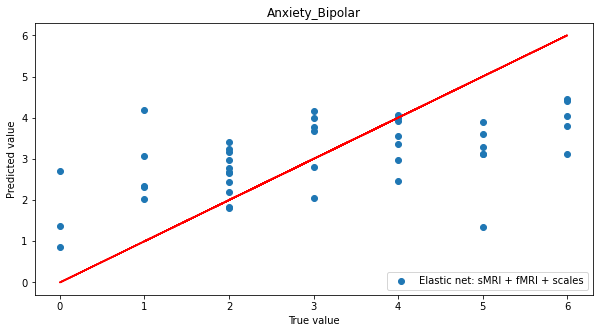

(171, 8007)
(171, 1)
Index([('tci', 'tci230t'), 'parstriangularis_MeanCurv_rh', ('chapper', 'chapper2'), ('barratt', 'barratt5'), ('chapper', 'chapper20')], dtype='object')


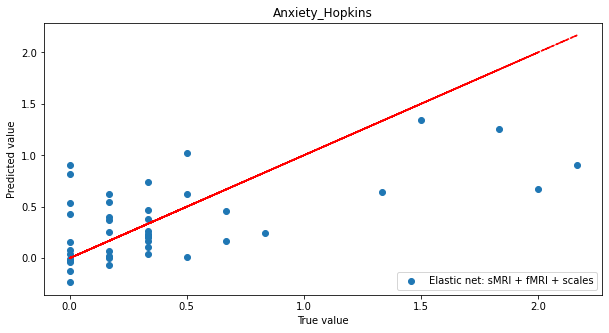

In [81]:
X = pd.concat((data_la_update, data_aroma_update, all_scale_values), axis = 1, join = 'inner')
X = pd.concat((X, schizo_ind), axis = 1, join = 'inner').drop(columns = ['participant_id'])
X = X[X.columns[np.where((X.isnull().sum(axis = 0) == 0).values)[0]]]
X = X[X.columns[np.where(X.std() != 0)[0]]]
X = (X - X.mean())/X.std()

for temp_scale in scales_df.columns:
  y = scales_df.loc[X.index][temp_scale]
  y = pd.concat((y, schizo_ind), axis = 1, join = 'inner').drop(columns = ['participant_id'])

  print(X.shape)
  print(y.shape)

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

  enet = ElasticNet(random_state = 42, max_iter = 100000, alpha = 0.01, l1_ratio = 0.1)
  
  enet.fit(X_train, y_train)

  test_pred = enet.predict(X_test)
  train_pred = enet.predict(X_train)

  
  mean_error = sm.mean_absolute_error(y_test, test_pred) 
  mse = sm.mean_squared_error(y_test, test_pred)
  median_error = sm.median_absolute_error(y_test, test_pred) 
  expl_var = sm.explained_variance_score(y_test, test_pred)
  r2 = sm.r2_score(y_test, test_pred)
  experiment.log_metrics({"mean absolute error": mean_error,
                          "mean squared error": mse,
                          "median absolute error": median_error,
                          "explained variance score": expl_var,
                          "R2": r2})
  
  performance[temp_scale].loc['scales + sMRI + fMRI']['mean absolute error'] = mean_error
  performance[temp_scale].loc['scales + sMRI + fMRI']['mean squared error'] = mse
  performance[temp_scale].loc['scales + sMRI + fMRI']['median absolute error'] = median_error
  performance[temp_scale].loc['scales + sMRI + fMRI']['explained variance score'] = expl_var
  performance[temp_scale].loc['scales + sMRI + fMRI']['R2'] = r2

  print(X.columns[np.argsort(np.abs(enet.coef_))[-5:]])
  
  plt.figure(figsize=(10, 5))
  plt.scatter(y_test, test_pred, label="Elastic net: sMRI + fMRI + scales")
  plt.plot(y_test, y_test, color = 'r', linestyle='dashdot')
  plt.xlabel("True value")
  plt.ylabel("Predicted value")
  plt.legend(loc='lower right')
  plt.title(temp_scale)
  plt.show()


In [82]:
for temp_scale in scales_df.columns:
  print("\n", temp_scale)
  print(performance[temp_scale])


 Mood/Dep_Hopkins
                      mean absolute error  mean squared error  median absolute error  explained variance score        R2
scales                           0.421673            0.267837               0.365295                  0.021223  0.020642
scales + sMRI                    0.399692            0.274074               0.317308                 -0.156197 -0.179624
scales + sMRI + fMRI             0.442021            0.331978               0.389409                  0.035162  0.030503

 Mood_Bipolar
                      mean absolute error  mean squared error  median absolute error  explained variance score        R2
scales                           1.043116            1.894548               0.794222                  0.427125  0.423955
scales + sMRI                    1.033773            1.668140               1.010189                  0.421471  0.330531
scales + sMRI + fMRI             1.152881            2.013724               1.045338                  0.279706  0.27645

It can be seen that adding sMRI and fMRI to transdiagnostic symptom severity prediction model improves the model for some symptoms (for example, Anxiety_Hopkins or Mood/Dep_Hopkins), but not for others (for example, Mood_Bipolar or Anhedonia_Chapsoc). Interistingly, for some traits 'scales + sMRI' model works the best (for example, Anxiety_Bipolar or Anhedonia_Chapphy).